In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode 
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
# no_of_partitions = 2
# km = KMeans(
#     n_clusters=no_of_partitions, init='random',
#     n_init=1, max_iter=100,
#     tol=1e-01, random_state=4)

# fitted_km = km.fit(X)
# # prediction will be obtained for all the samples
# prediction = fitted_km.predict(X)
# d = prediction

In [3]:
# no_of_partitions = 2
# km = KMeans(
#     n_clusters=no_of_partitions, init='random',
#     n_init=1, max_iter=10000,
#     tol=1e-01, random_state=8)

# fitted_km = km.fit(X)
# # prediction will be obtained for all the samples
# prediction = fitted_km.predict(X)
# d = prediction

In [4]:
# d

In [5]:
# cm = confusion_matrix(y, d)
# cm_argmax = cm.argmax(axis=0)
# if (cm_argmax[0] == cm_argmax[1]):
#     correct_d = d
# else:
#     correct_d = np.array([cm_argmax[i] for i in d])

In [6]:
# correct_d

In [7]:
# acc = accuracy_score(correct_d, y)

In [8]:
# acc

In [16]:
def get_ht_new(X, y, Dti, no_of_Q):
    '''
    This function is used for returning the partitioning of the X's
    no_of_Q : represents the number of Q samples that must be choosen from all the M samples
    '''
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
#     print('----------> Max DTI', ind_max, X[ind_max])


    no_of_partitions = 2
#     km = KMeans(
#             n_clusters=no_of_partitions, init='random',
#             n_init=1, max_iter=10000,
#             tol=1e-01, random_state=8)


    km = KMeans(
        n_clusters=no_of_partitions, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

    # now we will pass the corresponding X and parts with the Q samples to train the model 
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X, sample_weight = 1000000*Dti)
    d = prediction
    
    print('-> old predictions', d)

    cm = confusion_matrix(y, d)
    cm_argmax = cm.argmax(axis=0)
    if (cm_argmax[0] == cm_argmax[1]):
        correct_d = d
    else:
        correct_d = np.array([cm_argmax[i] for i in d])
    
    print('-> Corrected predictions', correct_d)
    
    for i in range(len(correct_d)):
        if correct_d[i] == 1:
            correct_d[i] = 1
        else:
            correct_d[i] = -1
    
    print('-> Corrected predictions', correct_d)
    
    return  correct_d, fitted_km

In [17]:
# def get_ht_new(X, y,Dti):
#     '''
#     This function is used for returning the partitioning of the X's
#     no_of_Q : represents the number of Q samples that must be choosen from all the M samples
#     '''
#     # we will extract the Q values with top Dti's
#     Dti = 10000000*np.array(Dti)
#     #ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]

# #     no of paritions = 2
#     no_of_paritons = 2
#     km = KMeans(
#         n_clusters=no_of_partitions, init='random',
#         n_init=1, max_iter=100,
#         tol=1e-01, random_state=4)

#     # now we will pass the corresponding X and parts with the Q samples to train the model 
#     fitted_km = km.fit(X, sample_weight = Dti)
#     # prediction will be obtained for all the samples
#     prediction = fitted_km.predict(X, sample_weight = Dti)
#     d = prediction
    
#     #print('-> old predictions', d)

#     cm = confusion_matrix(y, d)
#     cm_argmax = cm.argmax(axis=0)
#     if (cm_argmax[0] == cm_argmax[1]):
#         correct_d = d
#     else:
#         correct_d = np.array([cm_argmax[i] for i in d])
    
#     #print('-> Corrected predictions', correct_d)
    
#     for i in range(len(correct_d)):
#         if correct_d[i] == 1:
#             correct_d[i] = 1
#         else:
#             correct_d[i] = -1

#     return  correct_d, fitted_km

In [18]:
def classical_adaboost(X, y, T):
    
    y_mod = np.full(len(y), 1)
    y_mod[np.where(np.array(y) == 0)] = -1
    print('y_mod', y_mod)

    ht = []
    alphas = []
    Dt = []
    Dt.append(np.full(len(X), 1/len(X)))
    fin_acc = []
    classifs = []

    for t in range(T):

        Dti = Dt[t]
        
        print('----------ITERATION {} ----------'.format(t+1))
        print(' ')
        h, fitted_km = get_ht_new(X, y,Dti, 4)
        classifs.append(fitted_km)
        print('Weak Hypothesis of Base Classifier for iteration {}: '.format(t+1), h)
        print(' ')
        print('Accuracy of hypothesis calculated normally', accuracy_score(y_mod, h))
        
        # ----------Weighted Error----------------
        eps_t = 0
        for i in range(len(h)):
            
            if(y_mod[i] != h[i]):
                eps_t += Dti[i]

        print('Weighted Error for iteration {} (epsilon_t): '.format(t+1), eps_t)
        if(eps_t >0.49 and eps_t < 0.5008):
            eps_t -= 0.08
        print('Smoothed Weighted Error for iteration {} (epsilon_t): '.format(t+1), eps_t)
        print(' ')

        
        # --------------Margin-------------------
        if (eps_t == 0):
            alpha_t = 0.0001 #considering No change in distribution required, 
        else:
            alpha_t = np.log((1-eps_t)/eps_t)/2
        print('Margin for iteration {} (alpha_T): '.format(t+1), alpha_t)
        print(' ')
        alphas.append(alpha_t)

        
        # ----------------Z_t---------------------
        Z_t = 0
        for i in range(len(h)):
            Z_t += Dti[i]*np.exp(-alpha_t* y_mod[i]*h[i])
            
        print('Z_t for iteration {}: '.format(t+1), Z_t)
        print(' ')

        
        # -----------Distribution Update-----------
        Dti_up = []
        for i in range(len(h)):
            Dti_up.append(Dti[i]*np.exp(-alpha_t* y_mod[i]*h[i])/Z_t)
        print('Updated Distribution at iteration {}: '.format(t+1), Dti_up)
        print(' ')
        Dt.append(Dti_up)

        
        # ---------Final Strong Hypothesis-----------
        ht.append(h)
        Hx = []
        for i in range(len(alphas)):
            Hx.append(alphas[i]*ht[i])
        
        print('Strong Hypothesis after {} iterations'.format(t+1))
        print(Hx)
        
        Hx = np.sum(Hx, axis = 0)

        Hx = [np.sign(i) for i in Hx]
        print('Strong Hypothesis after {} iterations'.format(t+1))
        print(Hx)

        
        acc = accuracy_score(Hx, y_mod)
        fin_acc.append(acc)
        print('Accuracy after {} iterations : '.format(t+1),acc)
        print(' ')
        print(' ')
        print(' ')
        
    print('Training Accuracies : ', fin_acc)
    
    return fin_acc, classifs, alphas

In [19]:
def Testing(classifiers, alpha_t, X, y, No_of_itr):
    
    ## all we need to do is to do prediction with the earlier trained classifiers
    ht = []
    accuracy_final_test = []
    pred=[]
    
    #change labels from 0,1 to -1,1
    h_mod = []
    
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)
            
            
    for t in range(No_of_itr):

        d = classifiers[t].predict(X)
        # ht.append(d)
        from scipy.stats import mode 
        from sklearn.metrics import confusion_matrix

        cm = confusion_matrix(y, d)
        cm_argmax = cm.argmax(axis=0)
        if (cm_argmax[0] == cm_argmax[1]):
            correct_d = d
        else:
            correct_d = np.array([cm_argmax[i] for i in d])
        
        print('-> Corrected predictions', correct_d)
        ht.append(correct_d)
        
        for i in range(len(ht[0])):
            if ht[t][i]==0:
                ht[t][i] = -1
            else:
                ht[t][i] = 1
    
    # now ht has all the particular values

    for t in range(No_of_itr):
        pred.append(alpha_t[t]*ht[t])
    print(pred)
    
    
    for t in range(No_of_itr):  
        final_pred=[]
        # adding up all the alpha*ht
        predsum = np.sum(pred[0:t+1], axis = 0)
        print(predsum)
        
        for i in range(len(X)):
            if predsum[i]>0:
                final_pred.append(1)
            else:
                final_pred.append(-1)

        print('-> Final Predictions: ',final_pred)
        accuracy_final_test.append(metrics.accuracy_score(y_mod,final_pred))
        
    print('Testing Accuracies : ', accuracy_final_test)    
    return final_pred, accuracy_final_test   
    

In [20]:
def plot_fn(acc, T, M, ds, Algo, train_test):
    
    plt.style.use('seaborn')
    plt.plot(list(range(T)), acc)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("{} {} {} Accuracy M={}".format(Algo,ds, train_test, M))
    plt.show()
    

# Breast Cancer

## M=64

In [21]:
X = np.array([[-0.92033957],
       [-0.62676039],
       [-0.28869688],
       [-0.4545198 ],
       [-0.5639226 ],
       [-0.13063581],
       [-0.12721978],
       [-0.84393553],
       [-0.8167348 ],
       [-0.86877809],
       [ 0.68405998],
       [-0.77438584],
       [-0.72603092],
       [-0.97403678],
       [ 0.82394382],
       [ 0.04393449],
       [-0.62029416],
       [-0.7575307 ],
       [-0.78364214],
       [-0.69133675],
       [ 0.4711372 ],
       [-0.86332019],
       [-0.7846598 ],
       [-0.97647863],
       [-0.91662612],
       [-0.9170126 ],
       [-0.79788711],
       [-0.92582589],
       [ 0.00207795],
       [-0.94046638],
       [ 0.28818783],
       [-0.85261899],
       [-0.26015489],
       [-0.81450528],
       [-0.66534136],
       [-0.99248397],
       [-0.71814302],
       [-0.85732167],
       [-0.40941704],
       [-0.26379642],
       [ 0.00921227],
       [-0.8450853 ],
       [-0.81489227],
       [-0.59669884],
       [-0.73294047],
       [-0.88816995],
       [ 0.09926307],
       [-0.88024481],
       [-0.71913121],
       [ 0.16490514],
       [-0.68072081],
       [-0.83252443],
       [-0.59845984],
       [ 0.06816907],
       [-0.75077876],
       [-0.67732812],
       [ 1.        ],
       [-0.51626161],
       [-0.65711506],
       [-0.73442944],
       [-0.86852521],
       [-0.75947735],
       [-0.63011559],
       [-0.77908732]])

y = np.array([1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1])


X_test = np.array([[-0.75423437],
       [-0.65602419],
       [ 0.21333776],
       [-0.51939951],
       [-0.81243976],
       [-0.79156646],
       [-0.80595879],
       [-0.69137113],
       [-0.79167719],
       [-0.63640346],
       [-0.65655968],
       [-0.60008819],
       [ 0.08046681],
       [-0.66995772],
       [-0.9143032 ],
       [-0.7346537 ],
       [-0.83086306],
       [-0.69154759],
       [-0.32046433],
       [-0.61913998],
       [-0.99949378],
       [ 0.32645699],
       [-0.9091592 ],
       [-0.38972082],
       [-0.836701  ],
       [-0.23793032],
       [-0.6540042 ],
       [-0.86902482],
       [-0.804716  ],
       [ 0.1423963 ],
       [-0.68438072],
       [-0.90523266],
       [-0.06363657],
       [ 0.13351811],
       [-0.8986342 ],
       [-0.67632821],
       [-0.83384046],
       [-0.24302343],
       [-0.11478386],
       [-0.1748094 ],
       [-0.59596087],
       [-0.83984607],
       [-0.57101925],
       [-0.72698474],
       [-0.67562877],
       [-0.41587335],
       [-1.        ],
       [-0.75527322],
       [-0.78762551],
       [ 0.15402963],
       [-0.24211366],
       [-0.75569997],
       [-0.63144063],
       [-0.82345331],
       [-0.81198364],
       [-0.58035185],
       [ 0.26857311],
       [-0.74967687],
       [ 0.39268594],
       [-0.46482929],
       [-0.80117135],
       [-0.32990005],
       [-0.97846964],
       [-0.75533414]])


y_test = np.array([1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1])


In [22]:
T = 25 #num_iterations
fin_acc, classifs, alphas = classical_adaboost(X, y, T)

y_mod [ 1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1
  1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1  1]
----------ITERATION 1 ----------
 
-> old predictions [0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
-> Corrected predictions [ 1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1
  1  1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 1:  [ 1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1
  1  1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 

       -0.1613867, -0.1613867, -0.1613867, -0.1613867])]
Strong Hypothesis after 8 iterations
[1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0]
Accuracy after 8 iterations :  0.875
 
 
 
----------ITERATION 9 ----------
 
-> old predictions [0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
-> Corrected predictions [1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
-> Corrected predictions [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -

       -0.1613867, -0.1613867, -0.1613867, -0.1613867])]
Strong Hypothesis after 16 iterations
[1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0]
Accuracy after 16 iterations :  0.875
 
 
 
----------ITERATION 17 ----------
 
-> old predictions [0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
-> Corrected predictions [1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
-> Corrected predictions [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  

-> Corrected predictions [1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
-> Corrected predictions [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 22:  [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.890625
Weighted Error for iteration 22 (epsilon_t):  0.5800000000000005
Smoothed Weighted Error for iteration 22 (epsilon_t):  0.5800000000000005
 
Margin for iteration 22 (alpha_T):  -0.1613866961315266
 
Z_t for iteration 22:  0.9871170143402458
 
Updated Distribution at iteration 22:  [0.00537820118364183, 0.0564036928957

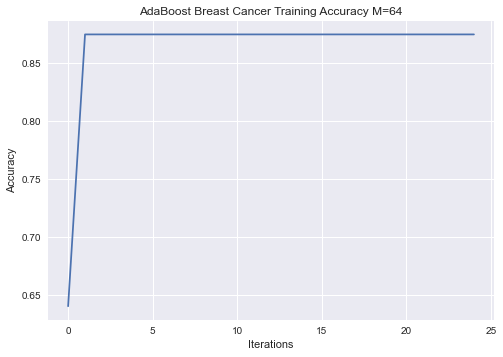

In [23]:
 plot_fn(fin_acc, 25, 64, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Training')

In [24]:
final_pred, test_acc = Testing(classifs, alphas, X_test, y_test, 25)

-> Corrected predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 

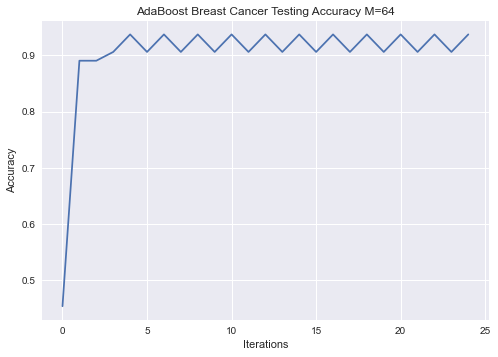

In [25]:
plot_fn(test_acc, 25, 64, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Testing')

y_mod [ 1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1
  1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1  1]
----------ITERATION 1 ----------
 
-> old predictions [0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
-> Corrected predictions [ 1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1
  1  1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 1:  [ 1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1
  1  1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 

-> old predictions [0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
-> Corrected predictions [1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
-> Corrected predictions [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 10:  [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.890625
Weighted Error for iteration 10 (epsilon_t):  0.5800000000000003
Smoothed Weighted Error for iteration 10 (epsilon_t):  0.5800000000000003
 
Margin for iteration 10 (alp

-> old predictions [0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
-> Corrected predictions [1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
-> Corrected predictions [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 17:  [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.890625
Weighted Error for iteration 17 (epsilon_t):  0.49999999999999956
Smoothed Weighted Error for iteration 17 (epsilon_t):  0.41999999999999954
 
Margin for iteration 17 (a

       -0.1613867, -0.1613867, -0.1613867, -0.1613867])]
Strong Hypothesis after 22 iterations
[1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0]
Accuracy after 22 iterations :  0.875
 
 
 
----------ITERATION 23 ----------
 
-> old predictions [0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
-> Corrected predictions [1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
-> Corrected predictions [ 1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1  1
  

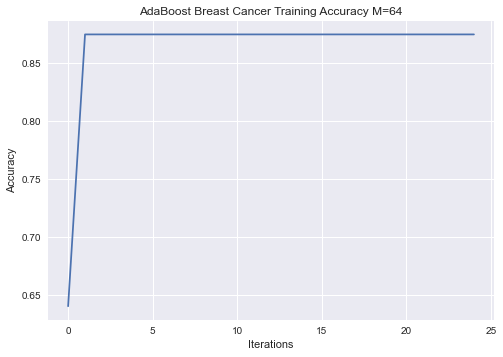

-> Corrected predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]
-> Corrected predictions [1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 

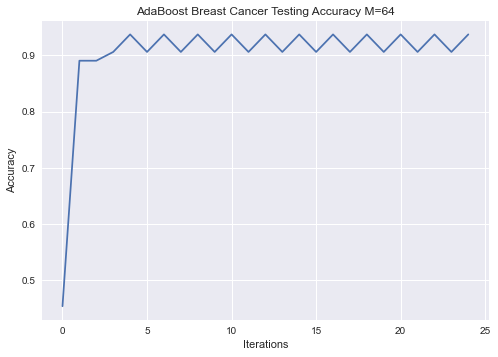

In [27]:
T = 25 #num_iterations
fin_acc64m, classifs, alphas = classical_adaboost(X, y, T)

plot_fn(fin_acc64m, 25, 64, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Training')

final_pred, test_acc64m = Testing(classifs, alphas, X_test, y_test, 25)

plot_fn(test_acc64m, 25, 64, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Testing')

## M = 32

In [28]:
X = np.array([[-0.52961818],
       [-0.73694129],
       [-0.98076452],
       [ 0.30469623],
       [-0.78349866],
       [-0.48788974],
       [-0.79870995],
       [ 0.25658932],
       [-0.70611322],
       [-0.74200188],
       [-0.7363877 ],
       [ 0.31199637],
       [-0.97364873],
       [ 0.71250752],
       [-0.55861402],
       [-0.63612516],
       [-0.90847131],
       [-0.54241534],
       [-0.21227206],
       [-0.49821623],
       [-0.7787262 ],
       [-0.69581626],
       [-0.77763277],
       [ 0.38337651],
       [-0.02174895],
       [-1.        ],
       [-0.63179088],
       [-0.9240283 ],
       [-0.83105823],
       [-0.61640269],
       [-0.95954346],
       [-0.81083621]])
y = np.array([1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1])

X_test = np.array([[-0.40839483],
       [-0.3025159 ],
       [-0.56281703],
       [ 1.        ],
       [-0.51608625],
       [-0.30182866],
       [-0.89821949],
       [-0.3258409 ],
       [ 0.24403701],
       [-0.08547389],
       [-0.81397378],
       [-0.52275241],
       [-0.84506346],
       [ 0.06944435],
       [ 0.12100471],
       [-0.82295834],
       [-0.56187142],
       [-0.47338434],
       [ 0.27271194],
       [-0.40050862],
       [-0.44610167],
       [-0.69609962],
       [-0.82142116],
       [-0.79394096],
       [-0.73949103],
       [-0.27940424],
       [ 0.80421303],
       [-0.32988797],
       [-0.78661245],
       [-0.75657348],
       [-0.77425805],
       [-0.89459281]])
y_test = np.array([1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1])


In [29]:
T = 25 #num_iterations
fin_acc32m, classifs, alphas = classical_adaboost(X, y, T)

y_mod [ 1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1
 -1  1  1  1  1  1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1
 -1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1
 -1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.78125
Weighted Error for iteration 1 (epsilon_t):  0.21875
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.21875
 
Margin for iteration 1 (alpha_T):  0.6364828379064438
 
Z_t for iteration 1:  0.8267972847076849
 
Updated Distribution at iteration 1:  [0.07142857142857141, 0.01999999999999999, 0.01999999999999999, 0.01999999999999999, 0.01999999999999

        0.1613867,  0.1613867])]
Strong Hypothesis after 13 iterations
[-1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0]
Accuracy after 13 iterations :  0.78125
 
 
 
----------ITERATION 14 ----------
 
-> old predictions [1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0]
-> Corrected predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 14:  [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 14 (epsilon_t):  0.5800000000000002
Smoothed Weighted Error for iteration 14 (epsilon_t):  0.5800000000000002
 
Margin for iteration 14 (al

        0.1613867,  0.1613867])]
Strong Hypothesis after 23 iterations
[-1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0]
Accuracy after 23 iterations :  0.78125
 
 
 
----------ITERATION 24 ----------
 
-> old predictions [1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0]
-> Corrected predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 24:  [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 24 (epsilon_t):  0.5800000000000003
Smoothed Weighted Error for iteration 24 (epsilon_t):  0.5800000000000003
 
Margin for iteration 24 (al

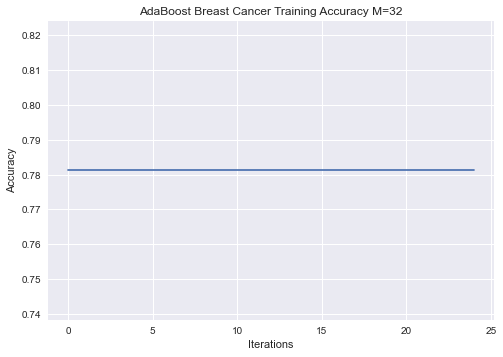

In [30]:
plot_fn(fin_acc32m, 25, 32, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Training')

In [31]:
final_pred, test_acc32m = Testing(classifs, alphas, X_test, y_test, 25)

-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]

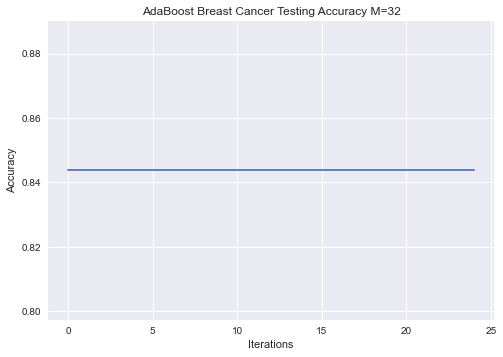

In [32]:
plot_fn(test_acc32m, 25, 32, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Testing')

y_mod [ 1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1
 -1  1  1  1  1  1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1
 -1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1
 -1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.78125
Weighted Error for iteration 1 (epsilon_t):  0.21875
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.21875
 
Margin for iteration 1 (alpha_T):  0.6364828379064438
 
Z_t for iteration 1:  0.8267972847076849
 
Updated Distribution at iteration 1:  [0.07142857142857141, 0.01999999999999999, 0.01999999999999999, 0.01999999999999999, 0.01999999999999

-> old predictions [1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0]
-> Corrected predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 12:  [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 12 (epsilon_t):  0.5800000000000002
Smoothed Weighted Error for iteration 12 (epsilon_t):  0.5800000000000002
 
Margin for iteration 12 (alpha_T):  -0.1613866961315259
 
Z_t for iteration 12:  0.9871170143402455
 
Updated Distribution at iteration 12:  [0.06868131868131866, 0.02083333333333333, 0.02083333333333333, 0.02083333333333333, 0.02083333333333333, 0.06868131868131866, 0.06868131868131866, 0.02083333333333333, 0.02083333333333333, 0.02083333333333333, 0.02

-> old predictions [1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0]
-> Corrected predictions [0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1]
-> Corrected predictions [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 21:  [-1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 21 (epsilon_t):  0.49999999999999983
Smoothed Weighted Error for iteration 21 (epsilon_t):  0.4199999999999998
 
Margin for iteration 21 (alpha_T):  0.1613866961315259
 
Z_t for iteration 21:  1.0130511230913843
 
Updated Distribution at iteration 21:  [0.07967032967032969, 0.017499999999999995, 0.017499999999999995, 0.017499999999999995, 0.017499999999999995, 0.07967032967032969, 0.07967032967032969, 0.017499999999999995, 0.017499999999999995, 0.01749999999999999

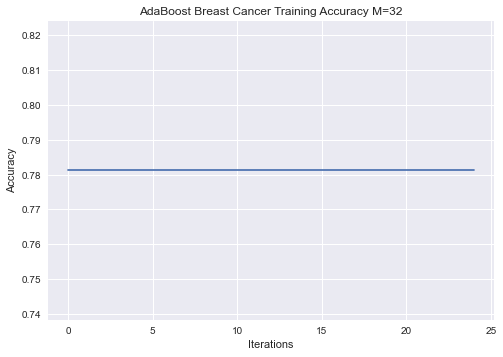

-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1]

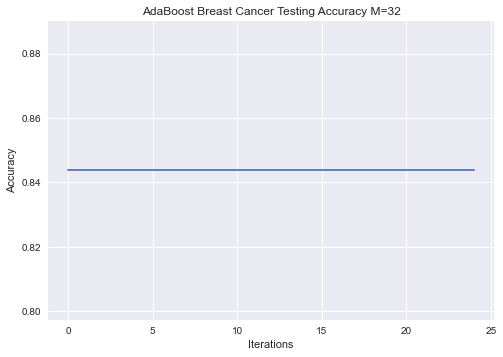

In [34]:
T = 25 #num_iterations
fin_acc32m, classifs, alphas = classical_adaboost(X, y, T)

plot_fn(fin_acc32m, 25, 32, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Training')

final_pred, test_acc32m = Testing(classifs, alphas, X_test, y_test, 25)

plot_fn(test_acc32m, 25, 32, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Testing')

## M = 16

In [35]:
X = np.array([[-0.76764442],
       [-0.61776561],
       [-0.76501246],
       [ 0.13807384],
       [-0.61909054],
       [ 0.36288268],
       [-1.        ],
       [-0.61300765],
       [-0.33114908],
       [-0.65033625],
       [-0.79890335],
       [-0.56009028],
       [ 0.10323057],
       [-0.52076065],
       [-0.89158817],
       [-0.73638509]])

y = np.array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]
)

X_test = np.array([[-0.95872091],
       [-0.92576013],
       [-0.73496398],
       [-0.79805629],
       [-0.57538087],
       [-0.49002715],
       [ 0.72440735],
       [ 1.        ],
       [-0.56658794],
       [-0.34205072],
       [-0.83562247],
       [-0.68286875],
       [-0.74067301],
       [-0.74345532],
       [-0.9301953 ],
       [-0.81564803]])

y_test = np.array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1])



In [36]:
T = 25 #num_iterations
fin_acc, classifs, alphas = classical_adaboost(X, y, T)

y_mod [ 1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [ 1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [ 1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.6875
Weighted Error for iteration 1 (epsilon_t):  0.3125
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.3125
 
Margin for iteration 1 (alpha_T):  0.39422868018213514
 
Z_t for iteration 1:  0.9270248108869579
 
Updated Distribution at iteration 1:  [0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.1, 0.1, 0.04545454545454545, 0.04545454545454545, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545]
 
Strong Hypothesis after 1 iterations
[array([ 0.3942286

-> old predictions [0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0]
-> Corrected predictions [1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1]
-> Corrected predictions [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 14:  [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 14 (epsilon_t):  0.5000000000000001
Smoothed Weighted Error for iteration 14 (epsilon_t):  0.4200000000000001
 
Margin for iteration 14 (alpha_T):  0.16138669613152526
 
Z_t for iteration 14:  1.0130511230913848
 
Updated Distribution at iteration 14:  [0.027096774193548397, 0.17559633027522933, 0.027096774193548397, 0.027096774193548397, 0.17559633027522933, 0.027096774193548397, 0.027096774193548397, 0.17559633027522933, 0.05961290322580643, 0.027096774193548397, 0.027096774193548397, 0.05321100917431193, 0.027096774193548397, 0.08941935483870969, 0.027096774193548397, 0.027096774193548397]
 
Strong Hypothesis after 14 i

-> old predictions [0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0]
-> Corrected predictions [1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1]
-> Corrected predictions [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 23:  [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 23 (epsilon_t):  0.5799999999999998
Smoothed Weighted Error for iteration 23 (epsilon_t):  0.5799999999999998
 
Margin for iteration 23 (alpha_T):  -0.1613866961315252
 
Z_t for iteration 23:  0.9871170143402452
 
Updated Distribution at iteration 23:  [0.03225806451612904, 0.15137614678899086, 0.03225806451612904, 0.03225806451612904, 0.15137614678899086, 0.03225806451612904, 0.03225806451612904, 0.15137614678899086, 0.07096774193548382, 0.03225806451612904, 0.03225806451612904, 0.04587155963302754, 0.03225806451612904, 0.1064516129032258, 0.03225806451612904, 0.03225806451612904]
 
Strong Hypothesis after 23 iterations
[

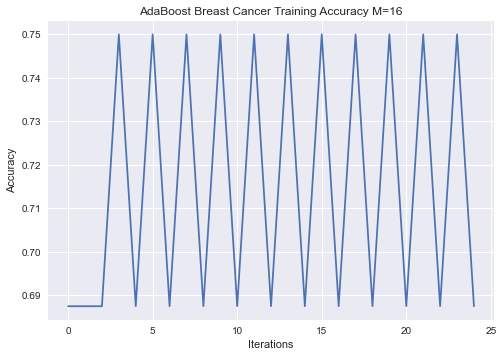

In [37]:
plot_fn(fin_acc, 25, 16, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Training')

In [38]:
final_pred, test_acc = Testing(classifs, alphas, X_test, y_test, 25)

-> Corrected predictions [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 

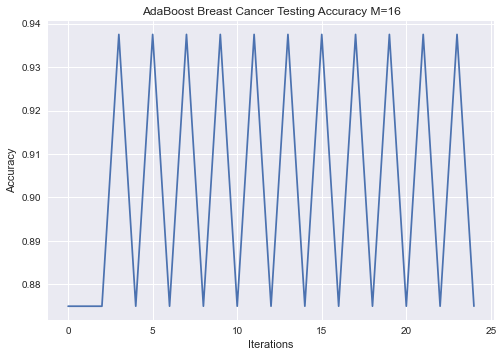

In [39]:
plot_fn(test_acc, 25, 16, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Testing')

y_mod [ 1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [ 1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [ 1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.6875
Weighted Error for iteration 1 (epsilon_t):  0.3125
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.3125
 
Margin for iteration 1 (alpha_T):  0.39422868018213514
 
Z_t for iteration 1:  0.9270248108869579
 
Updated Distribution at iteration 1:  [0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.1, 0.1, 0.04545454545454545, 0.04545454545454545, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545]
 
Strong Hypothesis after 1 iterations
[array([ 0.3942286

-> old predictions [0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0]
-> Corrected predictions [1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1]
-> Corrected predictions [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 13:  [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 13 (epsilon_t):  0.5799999999999998
Smoothed Weighted Error for iteration 13 (epsilon_t):  0.5799999999999998
 
Margin for iteration 13 (alpha_T):  -0.1613866961315252
 
Z_t for iteration 13:  0.9871170143402453
 
Updated Distribution at iteration 13:  [0.03225806451612904, 0.15137614678899086, 0.03225806451612904, 0.03225806451612904, 0.15137614678899086, 0.03225806451612904, 0.03225806451612904, 0.15137614678899086, 0.07096774193548383, 0.03225806451612904, 0.03225806451612904, 0.04587155963302754, 0.03225806451612904, 0.1064516129032258, 0.03225806451612904, 0.03225806451612904]
 
Strong Hypothesis after 13 iterations
[

-> old predictions [0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0]
-> Corrected predictions [1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1]
-> Corrected predictions [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 23:  [ 1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 23 (epsilon_t):  0.5799999999999998
Smoothed Weighted Error for iteration 23 (epsilon_t):  0.5799999999999998
 
Margin for iteration 23 (alpha_T):  -0.1613866961315252
 
Z_t for iteration 23:  0.9871170143402452
 
Updated Distribution at iteration 23:  [0.03225806451612904, 0.15137614678899086, 0.03225806451612904, 0.03225806451612904, 0.15137614678899086, 0.03225806451612904, 0.03225806451612904, 0.15137614678899086, 0.07096774193548382, 0.03225806451612904, 0.03225806451612904, 0.04587155963302754, 0.03225806451612904, 0.1064516129032258, 0.03225806451612904, 0.03225806451612904]
 
Strong Hypothesis after 23 iterations
[

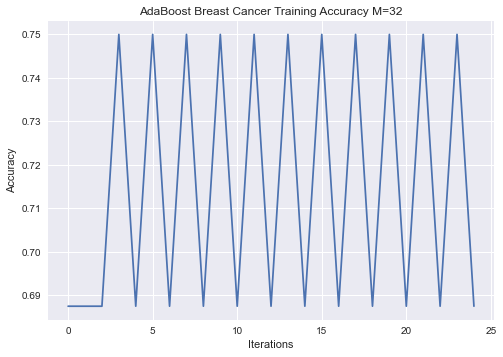

-> Corrected predictions [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 

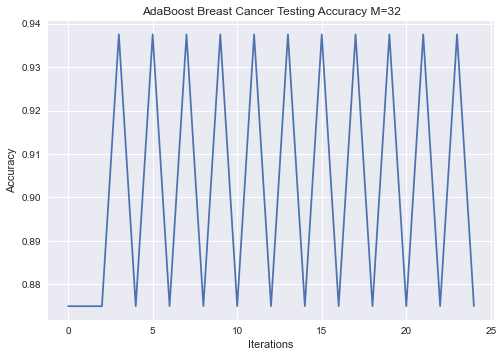

In [40]:
T = 25 #num_iterations
fin_acc16m, classifs, alphas = classical_adaboost(X, y, T)

plot_fn(fin_acc16m, 25, 32, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Training')

final_pred, test_acc16m = Testing(classifs, alphas, X_test, y_test, 25)

plot_fn(test_acc16m, 25, 32, ds = 'Breast Cancer', Algo= 'AdaBoost', train_test = 'Testing')

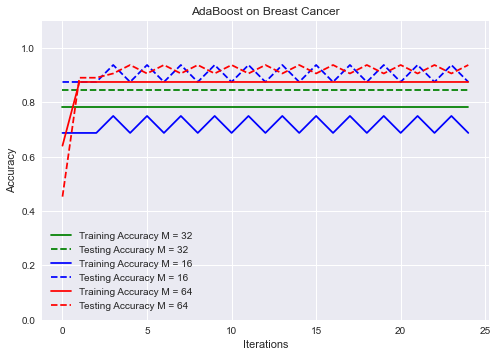

In [55]:
plt.style.use('seaborn')
plt.plot(list(range(25)), fin_acc32m, "g-", label = "Training Accuracy M = 32")
plt.plot(list(range(25)), test_acc32m, "g--", label = "Testing Accuracy M = 32")

plt.plot(list(range(25)), fin_acc16m, "b-", label = "Training Accuracy M = 16")
plt.plot(list(range(25)), test_acc16m, "b--", label = "Testing Accuracy M = 16")

plt.plot(list(range(25)), fin_acc64m, "r-", label = "Training Accuracy M = 64")
plt.plot(list(range(25)), test_acc64m, "r--", label = "Testing Accuracy M = 64")

# plt.plot([], [], 'k-', label="Training Accuracy")
# plt.plot([], [], 'k--', label="Testing Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("AdaBoost on Breast Cancer")
plt.ylim([0,1.1])

plt.show()

# MNIST

## M=64

In [41]:
X64 = np.array([[-0.80589907, -0.59042291, -0.05324325,  0.10774176, -0.04505932],
       [ 0.06256734, -0.37244006,  0.0939138 , -0.2033949 , -0.94811908],
       [-0.84338317, -0.6326198 , -0.43462352,  0.24523402, -0.52480534],
       [ 0.13286258,  0.37155658, -0.87001548,  0.70985865,  0.6677744 ],
       [-0.75234354, -0.21787303,  0.12046462, -0.59419401, -0.56680623],
       [ 0.28907508,  0.9888873 , -0.36947398, -0.3852527 ,  0.12494092],
       [-0.94193876, -0.07222975, -0.51910519, -0.34613681, -0.50121778],
       [-0.63461962, -0.66262997, -0.01359157, -0.20885209,  0.32881507],
       [ 0.26177535,  0.73210506,  0.14869942, -0.08739544, -0.41974897],
       [-0.87627756, -0.05459176, -0.79168413, -0.44217547, -0.76591014],
       [-0.31582251, -0.65735629,  0.80118443, -0.14383058,  0.05621122],
       [-0.56914731,  0.02827011, -0.70470652, -0.62345748,  0.07444681],
       [ 0.35079842,  0.84817601, -0.38494076, -0.29560828, -0.07015869],
       [ 0.60451149, -0.77078297, -0.00920281,  0.17409424, -0.29259797],
       [ 0.23017942,  0.13002239,  0.1935483 ,  0.2473952 , -0.39510758],
       [ 0.94377071, -0.63914724, -0.44823675, -0.35877896, -0.2279727 ],
       [-0.41203935, -0.63002251, -0.25803975, -0.13481458,  1.        ],
       [-0.84141311, -0.37295448,  0.23098801, -0.09279513, -0.30896296],
       [-0.63473418, -0.64862994, -0.34478505,  0.30493717, -0.31294345],
       [ 0.54624343, -0.05513775, -0.37989372,  0.44105009, -0.54167204],
       [ 0.41786759,  0.90609941, -0.47142637, -0.12383133,  0.07869459],
       [ 0.83676509, -0.60596934, -0.56257506, -1.        , -0.12157583],
       [ 0.09787885,  0.41570962,  0.05702348,  0.7133461 , -0.32991341],
       [ 0.56101992,  0.62038019, -0.28584764,  0.05462626, -0.96150592],
       [ 0.49179288, -0.1536601 , -0.20058942,  1.        , -0.23212819],
       [ 0.42401093, -0.29381199,  0.02061487,  0.68741985, -0.63409955],
       [-0.67235847, -0.68699306, -1.        ,  0.12998496, -0.64246139],
       [ 0.68981195, -0.7822776 , -0.45056316,  0.17824033, -0.28578779],
       [-0.8566584 , -0.04364493, -0.26908778, -0.35775043, -0.87088248],
       [-0.09183266,  0.77482135,  0.05847358, -0.03713341, -0.63098033],
       [ 0.82501212, -0.80820505, -0.18331782,  0.43321777, -0.49106175],
       [ 0.39893683,  0.94363918, -0.45686527,  0.24407125, -0.05909602],
       [ 0.69339013, -0.91467442, -0.23083126, -0.61828926, -0.31150299],
       [ 0.1360446 ,  0.4176652 ,  0.16521813,  0.28788609, -0.51930635],
       [ 0.44215386,  0.98543464, -0.37949666, -0.41211015,  0.05908244],
       [ 0.24224883,  0.81801481, -0.1429181 , -0.66253758, -0.39744601],
       [ 0.78826496, -0.72251302, -0.07685949, -0.01906448, -0.81606224],
       [ 0.64234617, -0.90884405, -0.01065299, -0.14171669, -0.5395039 ],
       [ 0.78331642, -0.79602718, -0.29497289, -0.38296365, -0.25876049],
       [ 0.58122718, -0.50820971, -0.39361292, -0.24785874,  0.49198399],
       [ 0.82427747, -0.77037464, -0.33859388,  0.59875024, -0.54046202],
       [-0.15491631,  0.42594546,  0.28120175, -0.12650848, -0.39095192],
       [-0.41265761, -0.778387  ,  0.38536974, -0.56097033,  0.27519472],
       [ 0.81281306, -0.82835321, -0.43001264,  0.54553452, -0.37301733],
       [-0.79622109, -0.04406497, -0.92528577, -0.37335828, -0.85511111],
       [ 0.12804201,  0.86948804, -0.01275777,  0.10466105,  0.11716134],
       [ 0.6583697 , -0.90448218, -0.07580081, -0.24559957, -0.43876332],
       [ 0.16191584,  0.4965871 ,  0.0479586 ,  0.21035375,  0.15673964],
       [ 0.30857441,  0.23363984,  0.06129492,  0.15414908,  0.07127983],
       [ 0.74245608, -0.6790161 , -0.23658274, -0.83579257, -0.14014044],
       [-0.15075894, -0.46560074,  0.50815128, -0.2837593 , -0.29533477],
       [-0.34931682,  0.03215297,  0.8454444 , -0.01232477, -0.14328294],
       [-0.85718266, -0.35816008, -0.53285026,  0.14980072, -0.38222436],
       [ 0.25723461,  0.63688708, -0.28527578, -0.29904661, -0.44305987],
       [ 0.17414132,  0.58749761,  0.09322319, -0.53893208, -0.92804504],
       [-0.39998583, -0.20541629,  0.78988065,  0.12372396, -0.14401889],
       [-0.66096707, -0.60768684, -0.08385178,  0.40744248, -0.24225684],
       [-0.87921722, -0.71534639, -0.43692453,  0.19842837,  0.1174938 ],
       [-0.81297545, -0.46532236, -0.31752754, -0.17918259,  0.04073442],
       [-0.91092209, -0.07973995, -0.33283798,  0.32994368, -0.60723175],
       [ 0.89593489, -1.        , -0.18398778, -0.54238746, -0.40547704],
       [-0.94852912,  0.07138546,  0.01882709, -0.01040221, -0.87775444],
       [-0.81245264, -0.36296099, -0.96669405,  0.22999089,  0.05613461],
       [-0.33243217, -0.33300052,  1.        , -0.05262967, -0.07337535]])

X_test64 = np.array([[-0.68707325, -0.50735238, -0.20700664, -0.62336223,  0.39806279],
       [ 0.46234745,  0.81775949, -0.44946658,  0.1140975 , -0.17951633],
       [ 0.61516826,  0.29117629, -0.20364858,  0.46090612,  0.00305875],
       [-0.50432232, -0.64050608,  0.13880843, -0.42755397,  0.47996396],
       [-0.58363044, -0.59302057, -0.36068798, -0.20546695,  0.42447254],
       [-0.77781706, -0.52822617,  0.1248982 , -0.39869912, -0.65804837],
       [-0.31182115, -0.16652907, -0.02315063,  0.05638778, -0.47035166],
       [-0.35714232, -0.56180839,  0.02707521, -0.3134225 ,  0.7454719 ],
       [ 0.40935228,  1.        , -0.52272328,  0.10199332,  0.13573632],
       [-0.5209226 , -0.19721416, -0.90344255, -0.43913667, -0.10011288],
       [-0.40235592, -0.6796702 , -0.49861898, -0.07365373,  0.85654452],
       [ 0.81742342, -0.54015171, -0.13383637, -0.1039951 , -0.93044641],
       [ 0.3254841 , -0.50934448,  0.04402021,  0.36110195, -0.37572541],
       [-0.09288116, -0.13640449,  0.05706831,  0.16841045, -0.95817001],
       [-0.90998517, -0.40430919, -0.86355457, -0.26217541, -0.064167  ],
       [-0.57775116, -0.76387782,  0.29964566, -0.30444234,  0.54161409],
       [ 0.21042602,  0.53453165,  0.05184494, -0.23258185, -0.75751172],
       [ 0.48320202,  0.85674321, -0.33808615, -0.17128284, -0.28369987],
       [-0.19770072, -0.68336291,  0.18640211, -0.35917056,  0.8291267 ],
       [ 0.65655214, -0.73443385, -0.42628468,  0.60888795,  0.01226754],
       [ 0.50016485,  0.0690652 , -0.45885945,  0.62442559,  0.06448148],
       [-0.38902654, -0.43851828,  0.66980889, -0.02364348,  0.01094794],
       [ 0.40796953, -0.85934891,  0.02097323, -0.25803196, -0.53040584],
       [-0.4956964 , -0.56031991,  0.74363441, -0.1163954 , -0.08862714],
       [-0.10882911,  0.64180596,  0.1375903 , -0.111592  , -0.30924287],
       [ 0.28332875,  0.79302765, -0.3118484 , -0.04220763, -0.12566824],
       [ 0.42676069, -0.61204992,  0.05231732, -0.25486205, -0.61785986],
       [ 0.60709358, -0.95289575, -0.18889892, -0.39078964, -0.212501  ],
       [-0.64455773, -0.20147303,  0.56736837, -0.29192325, -0.55664189],
       [ 0.45437401,  0.54042794, -0.13070526,  0.12284947, -0.55259124],
       [ 0.57638579, -0.67840819, -0.07071206, -0.21873946, -0.29933831],
       [-0.70554067, -0.51734514,  0.30348356, -0.5745156 , -0.12432887],
       [-0.51785336, -0.58458137,  0.53423814,  0.03205322, -0.05940223],
       [ 0.66912668, -0.78523877,  0.14110695, -0.00521186, -0.60630297],
       [-0.74108656, -0.13630257, -0.9809313 , -0.48456012, -0.29452577],
       [-0.64419453, -0.72115311, -0.14011673,  0.03085746, -0.41771499],
       [ 0.22878316, -0.07614892, -0.18493723,  0.4526321 , -0.1085523 ],
       [-0.8218347 , -0.28596485, -0.43286115, -0.48878151,  0.16100587],
       [ 0.53267724,  0.99697226, -0.51289751,  0.12752771, -0.36206251],
       [-0.46209981, -0.66716044, -0.10202221, -0.23609424,  0.47423212],
       [ 0.17014884,  0.40169187, -0.07279546,  0.04706547,  0.19721313],
       [ 0.59520936, -0.63509737, -0.39774277,  0.40608186, -0.057771  ],
       [-0.64006887, -0.33616701,  0.46128481, -0.0703224 , -0.05672336],
       [ 0.26505329, -0.21119132,  0.05232592,  0.21870707, -0.5844182 ],
       [ 0.25674746,  0.17546479,  0.12126193,  0.12813838, -0.9701474 ],
       [-0.46393382, -0.4577407 ,  0.69860785, -0.43353711, -0.15944243],
       [-0.58917778, -0.56371509,  0.41512294, -0.27969881, -0.02538025],
       [-0.66348932, -0.51538817,  0.25466218, -0.00358557, -0.35842899],
       [ 0.56951207, -0.68392313, -0.02628225,  0.17040521, -0.83197979],
       [-1.        , -0.32924987, -0.69087141, -0.44459176, -0.57811392],
       [ 1.        , -0.63579192, -0.49398102, -0.51258059, -0.30743351],
       [-0.83693098,  0.07785999, -0.41222783, -0.26083857, -0.66387623],
       [-0.05528876, -0.62425213,  0.25233409, -0.37310216,  0.73313602],
       [ 0.14568479,  0.43524995,  0.07727313,  0.0157491 , -0.53613886],
       [-0.02228015,  0.24813905,  0.03025536, -0.12589894, -0.97440804],
       [ 0.17895445,  0.64919227, -0.04496854, -0.23686312, -0.82210064],
       [-0.37993654, -0.45300412,  0.372467  , -0.02913794, -0.337318  ],
       [ 0.75550289, -0.85494843, -0.310949  , -0.81275764,  0.0746331 ],
       [ 0.38994431,  0.89259644, -0.24342355, -0.04604866, -0.03464256],
       [-0.73642587, -0.5752054 , -0.1700719 , -0.25048668,  0.33491302],
       [-0.73061136, -0.65033171, -0.55164925,  0.07918039,  0.44719878],
       [ 0.54081739,  0.17102128, -0.14932038,  0.52861686, -0.73708794],
       [ 0.46486667, -0.112343  ,  0.16271583, -0.00918502, -1.        ],
       [-0.74623427, -0.57101018,  0.00589433, -0.21381337,  0.34660433]])

y64 = [0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0]

y_test64 = [0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0]

X = X64
X_test = X_test64
y = y64
y_test = y_test64


In [111]:
T = 25 #num_iterations
fin_acc, classifs, alphas = classical_adaboost(X, y, T)

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1
  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1]
----------ITERATION 1 ----------
 
-> old predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1
 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
-> Corrected predictions [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 1:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

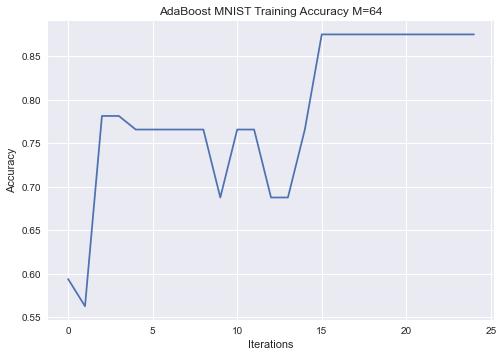

In [112]:
plot_fn(fin_acc, 25, 64, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Training')

In [113]:
final_pred, test_acc = Testing(classifs, alphas, X_test, y_test, 25)

-> Corrected predictions [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
-> Corrected predictions [0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1
 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1
 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0]
-> Corrected predictions [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
-> Corrected predictions [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0]
-> Corrected predictions [0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 

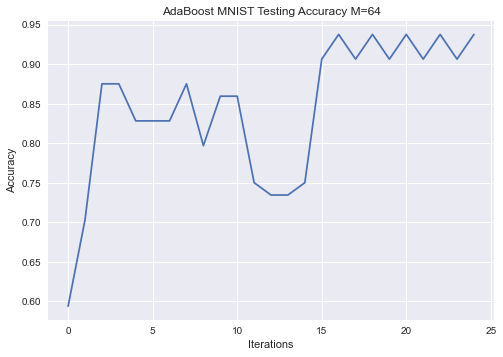

In [114]:
plot_fn(test_acc, 25, 64, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Testing')

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1
  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1]
----------ITERATION 1 ----------
 
-> old predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
-> Corrected predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1
 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
-> Corrected predictions [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 1:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

-> old predictions [1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0]
-> Corrected predictions [1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0]
-> Corrected predictions [ 1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1  1 -1  1  1 -1  1 -1 -1
  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1
  1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1]
Weak Hypothesis of Base Classifier for iteration 5:  [ 1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1  1 -1  1  1 -1  1 -1 -1
  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1
  1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1]
 
Accuracy of hypothesis calculated normally 0.53125
Weighted Error for iteration 5 (epsilon_t):  0.4608828093932141
Smoothed Weighted Error for iteration 5 (epsilon_t):  0.4608828093932141
 
Margin for iteration 5 (alpha_T)

-> old predictions [1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1]
-> Corrected predictions [1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1]
-> Corrected predictions [ 1  1  1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1 -1  1  1  1  1 -1  1  1
  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1
  1 -1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1]
Weak Hypothesis of Base Classifier for iteration 14:  [ 1  1  1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1 -1  1  1  1  1 -1  1  1
  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1
  1 -1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1]
 
Accuracy of hypothesis calculated normally 0.484375
Weighted Error for iteration 14 (epsilon_t):  0.41587082692732125
Smoothed Weighted Error for iteration 14 (epsilon_t):  0.41587082692732125
 
Margin for iteration 14 (a

Accuracy of hypothesis calculated normally 0.53125
Weighted Error for iteration 21 (epsilon_t):  0.49999999999999956
Smoothed Weighted Error for iteration 21 (epsilon_t):  0.41999999999999954
 
Margin for iteration 21 (alpha_T):  0.16138669613152648
 
Z_t for iteration 21:  1.0130511230913837
 
Updated Distribution at iteration 21:  [0.018332810440979955, 0.07810050732201367, 0.005317336165415176, 0.012404810162091655, 0.005317336165415176, 0.014422862232090402, 0.005317336165415176, 0.017097262066522012, 0.014422862232090402, 0.005317336165415176, 0.018332810440979955, 0.00342548860151812, 0.014422862232090402, 0.01521723150424897, 0.028241173352656086, 0.010411789976591403, 0.017097262066522012, 0.005317336165415176, 0.018332810440979955, 0.008191205211294959, 0.014422862232090402, 0.028793636480602066, 0.014422862232090402, 0.014422862232090402, 0.0035448098072392437, 0.010952811327672354, 0.013710435424230998, 0.010411789976591403, 0.005317336165415176, 0.014422862232090402, 0.0104

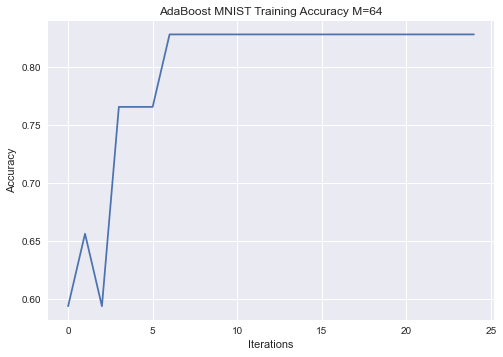

-> Corrected predictions [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
-> Corrected predictions [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0]
-> Corrected predictions [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
-> Corrected predictions [0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1]
-> Corrected predictions [0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0]
-> Corrected predictions [0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0]
-> Corrected predictions [0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 

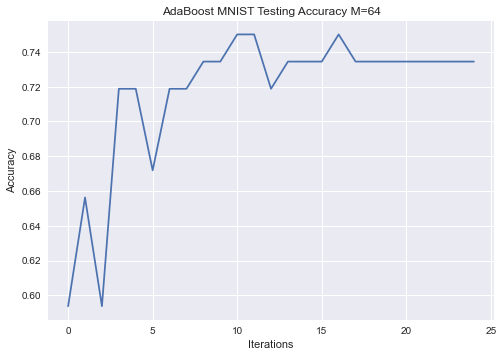

In [42]:
T = 25 #num_iterations
fin_acc64, classifs, alphas = classical_adaboost(X, y, T)
plot_fn(fin_acc64, 25, 64, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Training')
final_pred, test_acc64 = Testing(classifs, alphas, X_test, y_test, 25)
plot_fn(test_acc64, 25, 64, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Testing')

## M = 32

In [43]:
X = X64[:32]
X_test = X_test64[:32]
y = y64[:32] 
y_test = y_test64[:32]

In [44]:
T = 25 #num_iterations
fin_acc, classifs, alphas = classical_adaboost(X, y, T)

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1]
-> Corrected predictions [1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1]
-> Corrected predictions [ 1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [ 1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.84375
Weighted Error for iteration 1 (epsilon_t):  0.15625
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.15625
 
Margin for iteration 1 (alpha_T):  0.8431994767851144
 
Z_t for iteration 1:  0.7261843774138906
 
Updated Distribution at iteration 1:  [0.1, 0.018518518518518517, 0.018518518518518517, 0.018518518518518517, 0.018518518518518517, 0.01851

-> old predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 12:  [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
 
Accuracy of hypothesis calculated normally 0.46875
Weighted Error for iteration 12 (epsilon_t):  0.49999999999999983
Smoothed Weighted Error for iteration 12 (epsilon_t):  0.4199999999999998
 
Margin for iteration 12 (alpha_T):  0.1613866961315259
 
Z_t for iteration 12:  1.0130511230913843
 
Updated Distribution at iteration 12:  [0.06493095318288991, 0.02960262486328836, 0.012024250589424055, 0.019804648029639597, 0.012024250589424055, 0.019804648029639597, 0.012024250589424055, 0.09705432008749558, 0.02960262486328836, 0.012024250589424

-> old predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 21:  [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
 
Accuracy of hypothesis calculated normally 0.46875
Weighted Error for iteration 21 (epsilon_t):  0.5800000000000002
Smoothed Weighted Error for iteration 21 (epsilon_t):  0.5800000000000002
 
Margin for iteration 21 (alpha_T):  -0.1613866961315259
 
Z_t for iteration 21:  0.9871170143402456
 
Updated Distribution at iteration 21:  [0.07729875378915466, 0.025519504192489946, 0.014314584035028636, 0.023576961940047145, 0.014314584035028636, 0.023576961940047145, 0.014314584035028636, 0.08366751731680648, 0.025519504192489946, 0.0143145840350

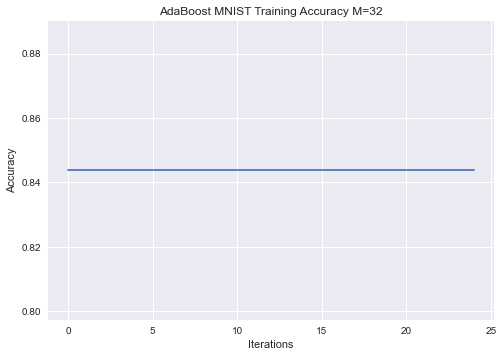

In [45]:
plot_fn(fin_acc, 25, 32, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Training')

In [46]:
final_pred, test_acc = Testing(classifs, alphas, X_test, y_test, 25)

-> Corrected predictions [0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]

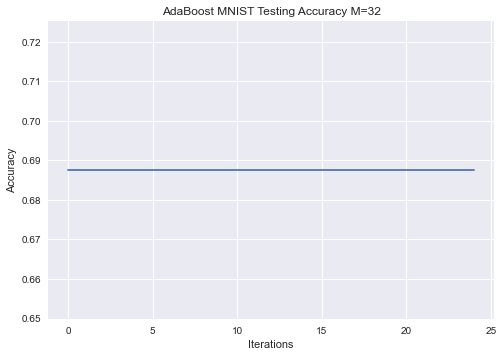

In [47]:
plot_fn(test_acc, 25, 32, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Testing')

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1]
-> Corrected predictions [1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1]
-> Corrected predictions [ 1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [ 1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.84375
Weighted Error for iteration 1 (epsilon_t):  0.15625
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.15625
 
Margin for iteration 1 (alpha_T):  0.8431994767851144
 
Z_t for iteration 1:  0.7261843774138906
 
Updated Distribution at iteration 1:  [0.1, 0.018518518518518517, 0.018518518518518517, 0.018518518518518517, 0.018518518518518517, 0.01851

       -0.1613867, -0.1613867])]
Strong Hypothesis after 12 iterations
[1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0]
Accuracy after 12 iterations :  0.84375
 
 
 
----------ITERATION 13 ----------
 
-> old predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 13:  [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
 
Accuracy of hypothesis calculated normally 0.46875
Weighted Error for iteration 13 (epsilon_t):  0.5800000000000002
Smoothed Weighted Error for iteration 13 (epsilon_t):  0.5800000000000002
 
Margin for iteration 13 (alpha_

        0.1613867,  0.1613867])]
Strong Hypothesis after 21 iterations
[1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0]
Accuracy after 21 iterations :  0.84375
 
 
 
----------ITERATION 22 ----------
 
-> old predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
-> Corrected predictions [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
Weak Hypothesis of Base Classifier for iteration 22:  [-1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1]
 
Accuracy of hypothesis calculated normally 0.46875
Weighted Error for iteration 22 (epsilon_t):  0.49999999999999983
Smoothed Weighted Error for iteration 22 (epsilon_t):  0.4199999999999998
 
Margin for iteration 22 (alpha

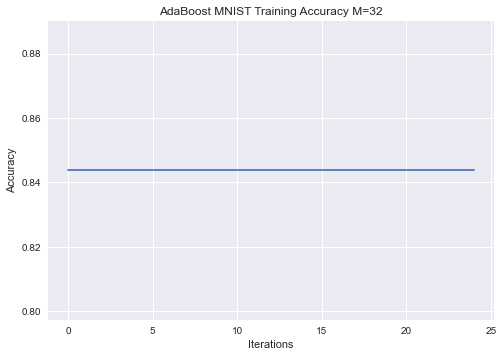

-> Corrected predictions [0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
-> Corrected predictions [0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]

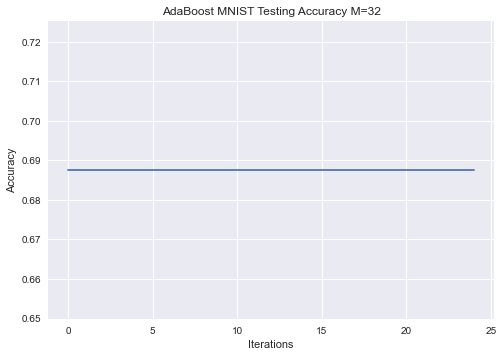

In [48]:
T = 25 #num_iterations
fin_acc32, classifs, alphas = classical_adaboost(X, y, T)
plot_fn(fin_acc32, 25, 32, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Training')
final_pred, test_acc32 = Testing(classifs, alphas, X_test, y_test, 25)
plot_fn(test_acc32, 25, 32, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Testing')

## M=16

In [49]:
X = X64[:16]
X_test = X_test64[:16]
y = y64[:16] 
y_test = y_test64[:16]

In [50]:
T = 25 #num_iterations
fin_acc, classifs, alphas = classical_adaboost(X, y, T)

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
-> Corrected predictions [0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
-> Corrected predictions [-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.6875
Weighted Error for iteration 1 (epsilon_t):  0.3125
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.3125
 
Margin for iteration 1 (alpha_T):  0.39422868018213514
 
Z_t for iteration 1:  0.9270248108869579
 
Updated Distribution at iteration 1:  [0.04545454545454545, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.1, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.04545454545454545]
 
Strong Hypothesis after 1 iterations
[array([-0.3942286

-> old predictions [0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1]
-> Corrected predictions [0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1]
-> Corrected predictions [-1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 13:  [-1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.6875
Weighted Error for iteration 13 (epsilon_t):  0.4999999999999998
Smoothed Weighted Error for iteration 13 (epsilon_t):  0.41999999999999976
 
Margin for iteration 13 (alpha_T):  0.16138669613152606
 
Z_t for iteration 13:  1.0130511230913846
 
Updated Distribution at iteration 13:  [0.003133914703105489, 0.11600000000000002, 0.003133914703105489, 0.09857547485863372, 0.003133914703105489, 0.09857547485863372, 0.11600000000000002, 0.003133914703105489, 0.006894612346832078, 0.11600000000000002, 0.09857547485863372, 0.11600000000000002, 0.09857547485863372, 0.11600000000000002, 0.003133914703105489, 0.003133914703105489]
 
Strong Hypothesis after 13 i

        0.17560193])]
Strong Hypothesis after 23 iterations
[-1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0]
Accuracy after 23 iterations :  0.6875
 
 
 
----------ITERATION 24 ----------
 
-> old predictions [1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0]
-> Corrected predictions [0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1]
-> Corrected predictions [-1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 24:  [-1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.75
Weighted Error for iteration 24 (epsilon_t):  0.4140851502274429
Smoothed Weighted Error for iteration 24 (epsilon_t):  0.4140851502274429
 
Margin for iteration 24 (alpha_T):  0.1735514209544385
 
Z_t for iteration 24:  0.9851266691924628
 
Updated Distribution at iteration 24:  [0.0005955068337962359, 0.09902336879257417, 0.0005955068337962359, 0.12499999999999997, 0.0005955068337962359, 0.12499999999999997, 0.09902336879257

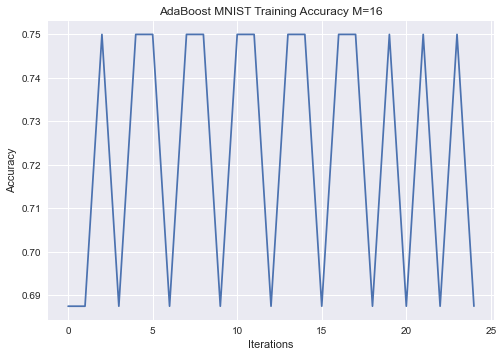

In [51]:
plot_fn(fin_acc, 25, 16, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Training')

In [52]:
final_pred, test_acc = Testing(classifs, alphas, X_test, y_test, 25)

-> Corrected predictions [0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 

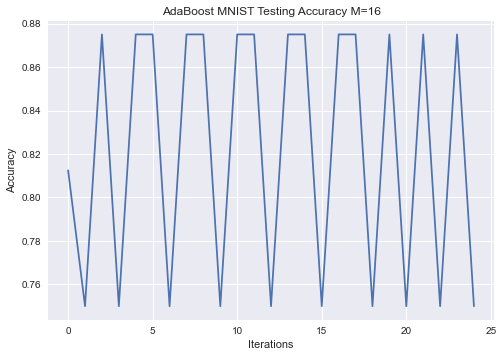

In [53]:
plot_fn(test_acc, 25, 16, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Testing')

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1]
----------ITERATION 1 ----------
 
-> old predictions [0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
-> Corrected predictions [0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
-> Corrected predictions [-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1]
Weak Hypothesis of Base Classifier for iteration 1:  [-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1]
 
Accuracy of hypothesis calculated normally 0.6875
Weighted Error for iteration 1 (epsilon_t):  0.3125
Smoothed Weighted Error for iteration 1 (epsilon_t):  0.3125
 
Margin for iteration 1 (alpha_T):  0.39422868018213514
 
Z_t for iteration 1:  0.9270248108869579
 
Updated Distribution at iteration 1:  [0.04545454545454545, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.1, 0.04545454545454545, 0.1, 0.04545454545454545, 0.1, 0.04545454545454545, 0.04545454545454545, 0.04545454545454545]
 
Strong Hypothesis after 1 iterations
[array([-0.3942286

Z_t for iteration 14:  0.9774004533186034
 
Updated Distribution at iteration 14:  [0.002587027019054329, 0.09575727568875089, 0.002587027019054329, 0.12500000000000003, 0.002587027019054329, 0.12500000000000003, 0.09575727568875089, 0.002587027019054329, 0.0056914594419195256, 0.09575727568875089, 0.12500000000000003, 0.09575727568875089, 0.12500000000000003, 0.09575727568875089, 0.002587027019054329, 0.002587027019054329]
 
Strong Hypothesis after 14 iterations
[array([-0.39422868,  0.39422868, -0.39422868, -0.39422868, -0.39422868,
       -0.39422868, -0.39422868, -0.39422868, -0.39422868, -0.39422868,
        0.39422868, -0.39422868, -0.39422868,  0.39422868,  0.39422868,
        0.39422868]), array([-0.61188772, -0.61188772, -0.61188772,  0.61188772, -0.61188772,
        0.61188772,  0.61188772, -0.61188772,  0.61188772,  0.61188772,
       -0.61188772,  0.61188772,  0.61188772, -0.61188772,  0.61188772,
        0.61188772]), array([-0.52604614,  0.52604614, -0.52604614, -0.526046

        0.17355142])]
Strong Hypothesis after 24 iterations
[-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0]
Accuracy after 24 iterations :  0.75
 
 
 
----------ITERATION 25 ----------
 
-> old predictions [0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1]
-> Corrected predictions [0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1]
-> Corrected predictions [-1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1  1  1]
Weak Hypothesis of Base Classifier for iteration 25:  [-1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1  1  1]
 
Accuracy of hypothesis calculated normally 0.6875
Weighted Error for iteration 25 (epsilon_t):  0.49511684396287087
Smoothed Weighted Error for iteration 25 (epsilon_t):  0.41511684396287085
 
Margin for iteration 25 (alpha_T):  0.17142603084621666
 
Z_t for iteration 25:  1.0130470480723135
 
Updated Distribution at iteration 25:  [0.0004952309231138147, 0.11602657190851408, 0.0004952309231138147, 0.10395156172197416, 0.0004952309231138147, 0.10395156172197416, 0.11602657

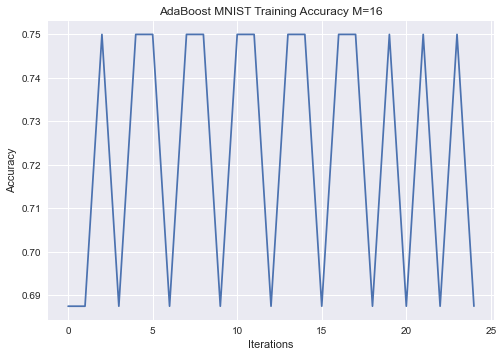

-> Corrected predictions [0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0]
-> Corrected predictions [0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 

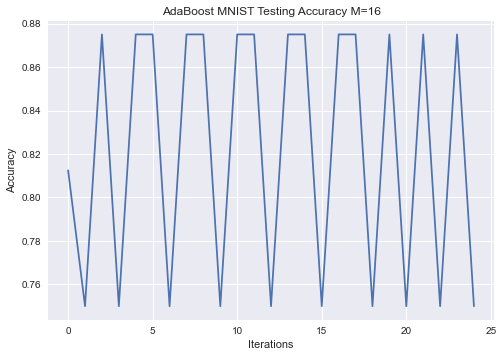

In [54]:
T = 25 #num_iterations
fin_acc16, classifs, alphas = classical_adaboost(X, y, T)
plot_fn(fin_acc16, 25, 16, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Training')
final_pred, test_acc16 = Testing(classifs, alphas, X_test, y_test, 25)
plot_fn(test_acc16, 25, 16, ds = 'MNIST', Algo= 'AdaBoost', train_test = 'Testing')

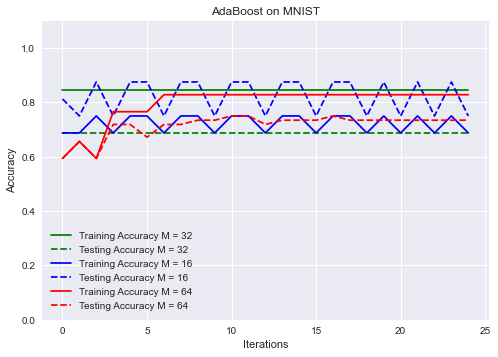

In [56]:
plt.style.use('seaborn')
plt.plot(list(range(25)), fin_acc32, "g-", label = "Training Accuracy M = 32")
plt.plot(list(range(25)), test_acc32, "g--", label = "Testing Accuracy M = 32")

plt.plot(list(range(25)), fin_acc16, "b-", label = "Training Accuracy M = 16")
plt.plot(list(range(25)), test_acc16, "b--", label = "Testing Accuracy M = 16")

plt.plot(list(range(25)), fin_acc64, "r-", label = "Training Accuracy M = 64")
plt.plot(list(range(25)), test_acc64, "r--", label = "Testing Accuracy M = 64")

# plt.plot([], [], 'k-', label="Training Accuracy")
# plt.plot([], [], 'k--', label="Testing Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("AdaBoost on MNIST")
plt.ylim([0,1.1])

plt.show()

### Note : This Approach also uses the 'yes'/'no' condition used in QAdaBoost while doing distribution update  and produces much smoother plots in all cases where accuracy stops oscillating towards the end.

In [24]:
def classical_adaboost_Q(X, y, T):
    
    y_mod = np.full(len(y), 1)
    y_mod[np.where(np.array(y) == 0)] = -1
    print('y_mod', y_mod)

    ht = []
    alphas = []
    Dt = []
    Dt.append(np.full(len(X), 1/len(X)))
    fin_acc = []
    classifs = []

    for t in range(T):

        Dti = Dt[t]
        
        print('----------ITERATION {} ----------'.format(t+1))
        print(' ')
        h, fitted_km = get_ht_new(X, y,Dti, 4)
        classifs.append(fitted_km)
        print('Weak Hypothesis of Base Classifier for iteration {}: '.format(t+1), h)
        print(' ')
        print('Accuracy of hypothesis calculated normally', accuracy_score(y_mod, h))
        
        # ----------Weighted Error----------------
        eps_t = 0
        for i in range(len(h)):
            
            if(y_mod[i] != h[i]):
                eps_t += Dti[i]
#                 print('--->y_mod, h', y_mod[i], h[i])
#                 print('------> eps_t', eps_t)
        print('Weighted Error for iteration {} (epsilon_t): '.format(t+1), eps_t)
        if(eps_t >0.49 and eps_t < 0.5008):
            eps_t -= 0.08
        print('Smoothed Weighted Error for iteration {} (epsilon_t): '.format(t+1), eps_t)
        print(' ')

        
        no_of_Q = 4
        delta = 1/(10*(no_of_Q * T*T))
        dti_up = []
        #################### updation of Dti #####################
        Q = 4
        
        ## here we will be taking the 'yes'/'no' condition into account
        if eps_t >= (1-delta)/(64*Q*T*T):
            print('yes')
            alpha_t = np.log(np.sqrt(1-eps_t)/np.sqrt(eps_t))
            Zt = 2*np.sqrt((1-eps_t)*eps_t)

            for i in range(len(Dti)):
                if(y_mod[i]==h[i]):
                    dti_up.append(Dti[i]*np.exp(-alpha_t)/((1+2*delta)*Zt))

                else:
                    dti_up.append(Dti[i]*np.exp(alpha_t)/((1+2*delta)*Zt))

        else:
            print('no')
            alpha_t = np.log(np.sqrt((Q*T*T) - 1))
            Zt = 2*(np.sqrt((Q*T*T) - 1)/(Q*T*T))

            for i in range(len(Dti)):
                if(y_mod[i]==h[i]):
                    dti_up.append(Dti[i]*np.exp(-alpha_t)*(2 - 1/(Q*T*T))/((1+2/(Q*T*T))*Zt))

                else:
                    dti_up.append(Dti[i]*np.exp(alpha_t)*(1/(Q*T*T))/((1+2/(Q*T*T))*Zt))

        print('THE ALPHA_T :' , alpha_t)
        alphas.append(alpha_t)
        # -----------Distribution Update-----------
#         Dti_up = []
#         for i in range(len(h)):
#             Dti_up.append(Dti[i]*np.exp(-alpha_t* y_mod[i]*h[i])/Z_t)
#         print('Updated Distribution at iteration {}: '.format(t+1), Dti_up)
#         print(' ')
        Dt.append(dti_up)

        print('THE h : ', h)
        print('Y_MOD : ', y_mod)
        # ---------Final Strong Hypothesis-----------
        ht.append(h)
        Hx = []
        for i in range(len(alphas)):
            Hx.append(alphas[i]*ht[i])
        
        print('Strong Hypothesis after {} iterations'.format(t+1))
        print(Hx)
        
        Hx = np.sum(Hx, axis = 0)

        Hx = [np.sign(i) for i in Hx]
        print('Strong Hypothesis after {} iterations'.format(t+1))
        print(Hx)

        
        acc = accuracy_score(Hx, y_mod)
        fin_acc.append(acc)
        print('Accuracy after {} iterations : '.format(t+1),acc)
        print(' ')
        print(' ')
        print(' ')
    print('Training Accuracies : ', fin_acc)
    
    return fin_acc, classifs, alphas